### Curing of epoxy.

The probability of bonding ($p$) is currently controlled by the activation energy ($E_a$) as an Arrhenius function 

$ p(E_a) = exp\Big(\frac{-E_a}{k_BT}\Big)$

In order to estimate an appropriate activation energy for a range of temperatures (0.1, 1, 2, 4, 6) kT, $p$ is plotted as a function of $E_a$ for these temperatures. Here an "appropriate" $E_a$ should yield considerabily different values of $p$ between the maximum and minimum temperatures considered.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

[ 0.001       0.10302041  0.20504082  0.30706122  0.40908163]


/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


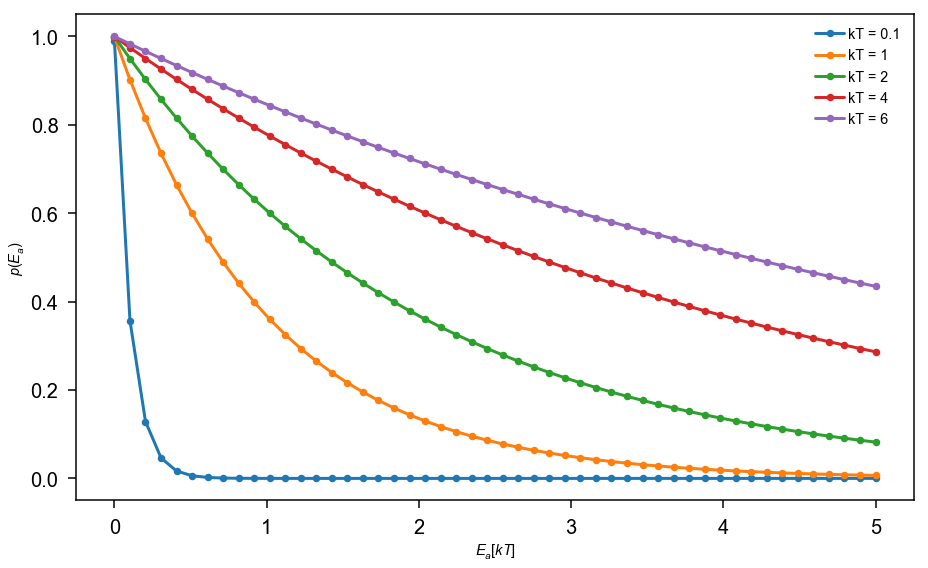

In [2]:
import numpy as np
kTs = [0.1,1,2,4,6]
delta_es = np.linspace(0.001,5,50)
print(delta_es[:5])
plt.figure(figsize=(13,8))
for kT in kTs:
    mb_stats = []
    for delta_e in delta_es:
        mb_stat = np.exp(-delta_e / kT)
        mb_stats.append(mb_stat)
    label = 'kT = {}'.format(kT)
    plt.plot(delta_es,mb_stats,marker='o',label=label)
plt.legend()
plt.xlabel('$E_a [kT]$')
plt.ylabel('$p(E_a)$')
plt.show()

From the above plot, an activation energy of 0.3 gives appreciable difference in bonding probability and should produce significant difference in cure percentages.

In [3]:
import epoxpy.abc_type_epoxy_simulation as es
import epoxpy.job as jb
import epoxpy.temperature_profile_builder as tpb
import os
import numpy as np
import shutil
import matplotlib
import signac


def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('out.log'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status


def run_epoxy_sim(sim_name, mix_time, mix_kt, temp_prof, bond, n_mul, shrink, legacy_bonding, ext_init_struct_path,
                  exclude_mixing_in_output, log_curing, curing_log_period, log_write, dcd_write, job, dt, density,
                  bond_period,activation_energy):

    fig_path = os.path.join(job.workspace(), 'temperature_profile.png')
    temp_temperature_profile = tpb.LinearTemperatureProfileBuilder(0)
    temp_temperature_profile.set_raw(temp_prof)
    temp_prof = temp_temperature_profile
    print('tempearture profile:{}'.format(temp_prof))
    fig = temp_prof.get_figure()
    fig.savefig(fig_path)
    in_path = os.path.join(job.workspace(), 'script_bckp.py')
    #shutil.copy(__file__, in_path)

    myEpoxySim = es.ABCTypeEpoxySimulation(sim_name, mix_time=mix_time, mix_kt=mix_kt, temp_prof=temp_prof, bond=bond,
                                           n_mul=n_mul, shrink=shrink, legacy_bonding=legacy_bonding,
                                           ext_init_struct_path=ext_init_struct_path,
                                           exclude_mixing_in_output=exclude_mixing_in_output, log_curing=log_curing,
                                           curing_log_period=curing_log_period, log_write=log_write,
                                           dcd_write=dcd_write, output_dir=job.workspace(), dt=dt, density=density,
                                           bond_period=bond_period, activation_energy=activation_energy)

    mySingleJobForEpoxy = jb.SingleJob(myEpoxySim)
    mySingleJobForEpoxy.execute()

    job.document['bond_percent'] = myEpoxySim.get_curing_percentage()
    log_path = os.path.join(job.workspace(), 'curing.log')
    np.savetxt(log_path, myEpoxySim.curing_log)

    curing_log = list(zip(*myEpoxySim.curing_log))
    fig = plt.figure()
    plt.xlabel('Time steps')
    plt.ylabel('Cure percent')
    plt.margins(x=0.1, y=0.1)
    plt.plot(curing_log[0], curing_log[1])
    plt.plot(curing_log[0], curing_log[1], 'or')
    fig_path = os.path.join(job.workspace(), 'curing_curve.png')
    fig.savefig(fig_path)

def init_job(state_point):
    project = signac.init_project('ABCTypeEpoxy', 'data/')
    job = project.open_job(state_point)
    job.init()
    job_status = get_status(job)
    print('job status:{}'.format(job_status))
    if job_status == 'init':
        fig_path = os.path.join(job.workspace(), 'temperature_profile.png')
        temp_temperature_profile = tpb.LinearTemperatureProfileBuilder(0)
        temp_temperature_profile.set_raw(job.sp.temp_prof)
        temp_prof = temp_temperature_profile
        print('tempearture profile:{}'.format(temp_prof))
        fig = temp_prof.get_figure()
        fig.savefig(fig_path)
    
    print('initialize', job)
    
def run_simulation(state_point):
    project = signac.init_project('ABCTypeEpoxy', 'data/')
    job = project.open_job(state_point)
    job.init()
    print('initialize', job)
    job_status = get_status(job)
    print('job status:{}'.format(job_status))
    if job_status == 'temperature-profile-created':
        run_epoxy_sim(job=job, **job.statepoint())

/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Assembling the jobs

job status:init
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x115202e10>
initialize e4386c35adb2d2baa0fa34b0cb7c3dee
job status:init
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x11c54cba8>
initialize 65ef6dfbc79b9c7c3be8b069a7414ed6
job status:init
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x1212fd160>
initialize 83a0b7823868f2a1af529da490923dea
job status:init
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x12adf59b0>
initialize 4a7b9739a6293b7949d63c78e3429895
job status:init
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x1188a2470>
initialize 8ca7b4da0b8ba8e0e4d5b7a19e35cb15


/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


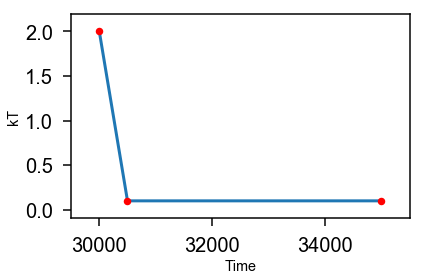

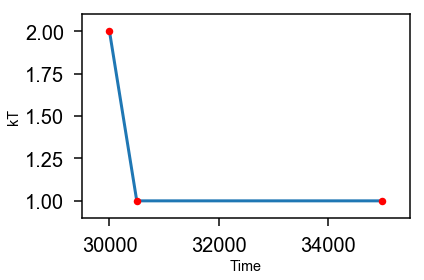

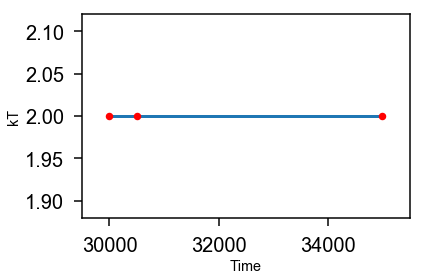

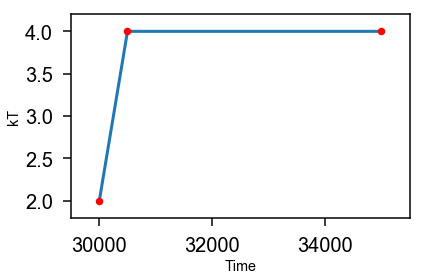

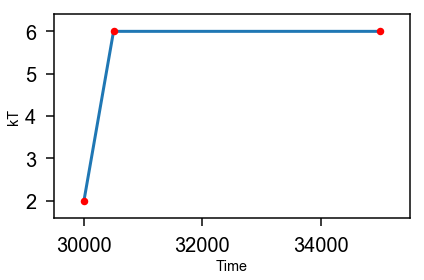

In [4]:
kTs = [0.1, 1, 2, 4, 6]
mixing_temperature = 2.0
mixing_time = 3e4
time_scale = 10

for kT in kTs:
    flat_temp_profile = tpb.LinearTemperatureProfileBuilder(initial_temperature=mixing_temperature,
                                                            initial_time=mixing_time)
    flat_temp_profile.add_state_point(50 * time_scale, kT)
    flat_temp_profile.add_state_point(450 * time_scale, kT)
    
    sp = {'sim_name': 'epoxy_curing_flat_temperature_profile_{}kT'.format(kT),
          'mix_time': mixing_time,
          'mix_kt': mixing_temperature,
          'temp_prof': flat_temp_profile.get_raw(),
          'bond': True,
          'n_mul': 1.0,
          'shrink': True,
          'legacy_bonding': False,
          'ext_init_struct_path': None,
          'exclude_mixing_in_output': False,
          'log_curing': True,
          'curing_log_period': 1e1,
          'log_write': 1e5,
          'dcd_write': 1e5,
          'bond_period': 1e1,
          'dt': 1e-2,
          'density': 1.0,
          'activation_energy':0.3}
    init_job(sp)

### The state points of the simulations and the temperature profiles suggested are shown below:

10.0
10.0
10.0
10.0
10.0


/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


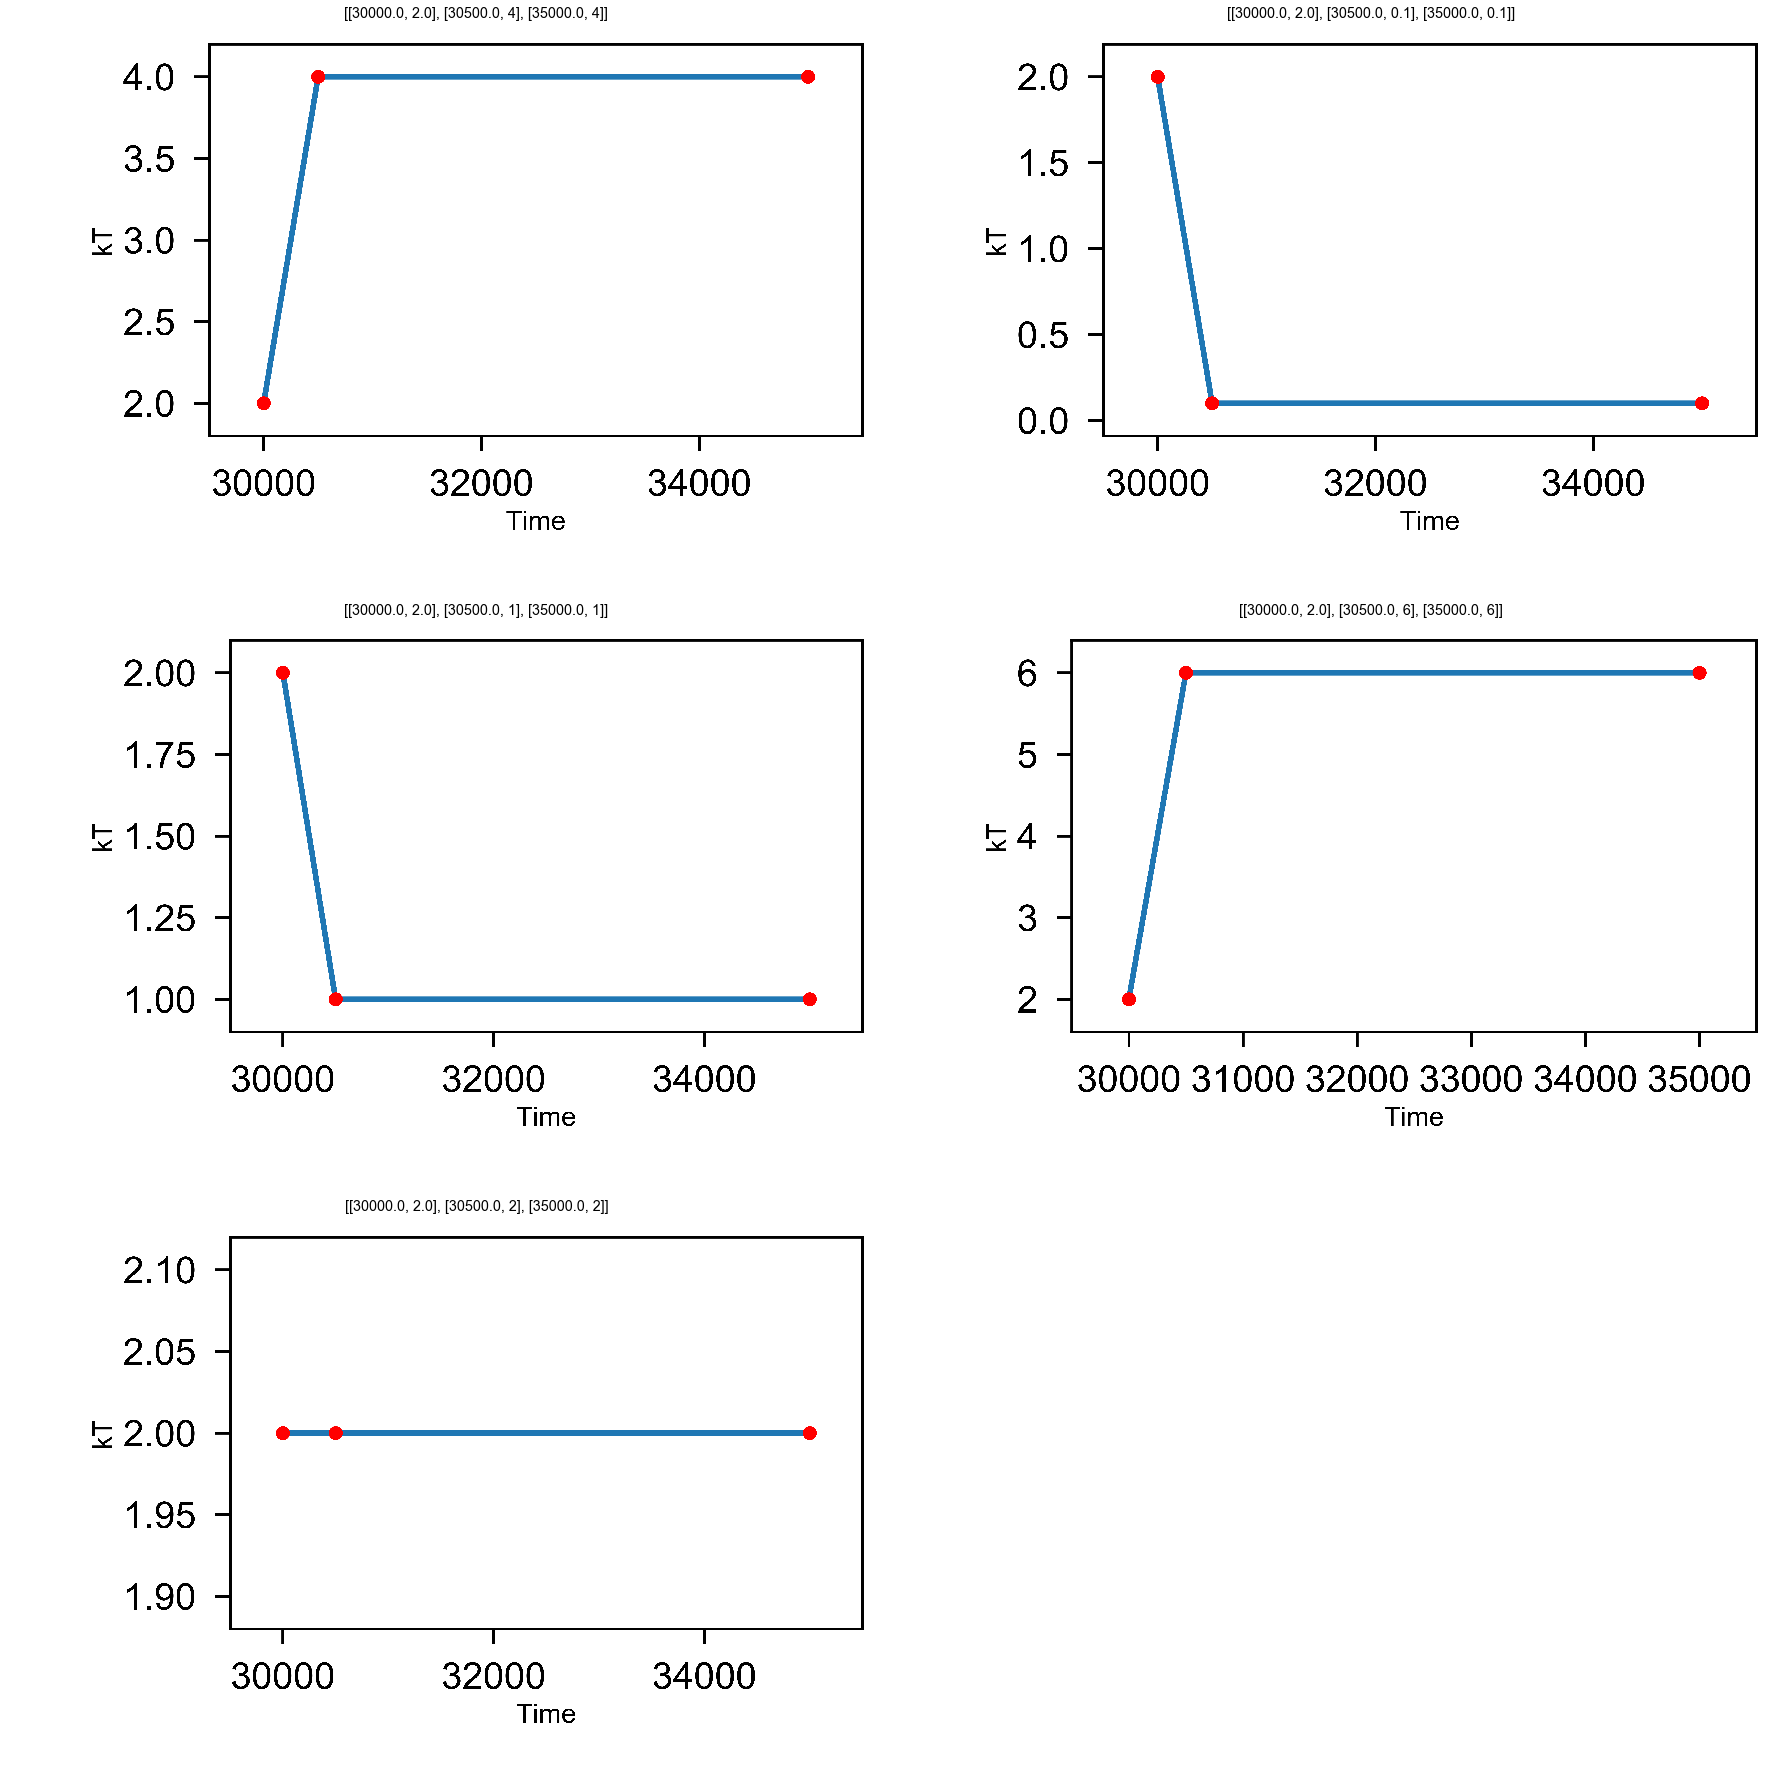

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

project = signac.init_project('ABCTypeEpoxy', 'data/')


jobs = project.find_jobs({'activation_energy':0.3,
                         'curing_log_period':1e1})
pltid=321
plt.figure(figsize=(25,25))
for job in jobs:
    if len(job.sp.temp_prof)>2:
        ax = plt.subplot(pltid)
        img=mpimg.imread(job.fn('temperature_profile.png'))
        ax.imshow(img,interpolation='nearest', aspect='auto')
        ax.set_axis_off()
        ax.set_title(job.sp.temp_prof)
        ax.autoscale(False)
        pltid+=1
        print(job.sp.curing_log_period)
plt.show()

### Now the jobs are runs

initialize 4a7b9739a6293b7949d63c78e3429895
job status:temperature-profile-created
tempearture profile:<epoxpy.temperature_profile_builder.LinearTemperatureProfileBuilder object at 0x118824e48>
md time: 5000.0
kwargs passed into ABCTypeEpoxySimulation: {'shrink': True, 'log_curing': True, 'curing_log_period': 10.0, 'legacy_bonding': False, 'exclude_mixing_in_output': False, 'ext_init_struct_path': None}
New single job created to run epoxy_curing_flat_temperature_profile_4kT
Executing epoxy_curing_flat_temperature_profile_4kT
Initializing epoxy_curing_flat_temperature_profile_4kT
Initializing HOOMD in ipython
HOOMD-blue v2.1.6 DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 04/12/17
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Phy

/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4770025368>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.2696, 1.6155, 1.0896), 0 bonds, id: 4769886560>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.4282, 1.6234, 1.3687), 0 bonds, id: 4769886560>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.5432, 1.7639, 1.3108), 0 bonds, id: 4769886560>" is elemen

Packing 2.0 C10 particles ..
notice(2): Reading /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/4a7b9739a6293b7949d63c78e3429895/initial.hoomdxml...
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 0
notice(2): 50 masses
notice(2): 3 particle types
notice(2): 18 bonds
notice(2): 50 charges
notice(2): Group "all" created containing 50 particles
Initial box dimension: 3
['0']
** starting run **
Time 00:00:00 | Step 1 / 1 | TPS 3.44742 | ETA 00:00:00
Average TPS: 3.42817
---------
** run complete **
Initial box dimension: Box: Lx=3.6840314986403864 Ly=3.6840314986403864 Lz=3.6840314986403864 xy=0.0 xz=0.0 yz=0.0 dimensions=3
Initializing HOOMD in ipython
notice(2): Reading /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/4a7b9739a6293b7949d63c78e3429895/initial.hoomdxml...
notice(2): Parser for node <acceleration> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 1
notice(2): 

*Warning*: Starting a run without an integrator set*Warning*: You are running without an integrator
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.


: Group "b-particles" created containing 20 particles
notice(2): Group "c-particles" created containing 20 particles
temperature profile [[30000.0, 2.0], [30500.0, 4], [35000.0, 4]]
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
Configuring outputs. output_dir: /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/4a7b9739a6293b7949d63c78e3429895
log_write: 100000.0 dcd_write: 100000.0
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 30
notice(2): Particles with 1 exclusions             : 4
notice(2): Particles with 2 exclusions             : 16
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
possible bonds

/Users/stephenthomas/projects/epoxy_sim/epoxpy/epoxy_simulation.py:224: UserWarning: genfromtxt: Empty input file: "/Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/4a7b9739a6293b7949d63c78e3429895/out.log"
  data = np.genfromtxt(fname=os.path.join(self.output_dir, 'out.log'), skip_header=True)
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4704685920>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.2696, 1.6155, 1.0896), 0 bonds, id: 4705637376>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.4282, 1.6234, 1

Time 00:00:00 | Step 1 / 1 | TPS 3.70377 | ETA 00:00:00
Average TPS: 3.69045
---------
** run complete **
Initial box dimension: Box: Lx=3.6840314986403864 Ly=3.6840314986403864 Lz=3.6840314986403864 xy=0.0 xz=0.0 yz=0.0 dimensions=3
Initializing HOOMD in ipython
notice(2): Reading /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/e4386c35adb2d2baa0fa34b0cb7c3dee/initial.hoomdxml...
notice(2): Parser for node <acceleration> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 1
notice(2): 50 images
notice(2): 50 velocities
notice(2): 50 masses
notice(2): 50 diameters
notice(2): 3 particle types
notice(2): 50 particle body values
notice(2): 18 bonds
notice(2): 50 charges
notice(2): 50 orientations
notice(2): 50 moments of inertia
notice(2): 50 angular moments
notice(2): Group "all" created containing 50 particles
notice(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" created containing 

arning*: You are running without an integrator
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.


rkspace/e4386c35adb2d2baa0fa34b0cb7c3dee/mixed.hoomdxml...
notice(2): Parser for node <acceleration> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 30001
notice(2): 50 images
notice(2): 50 velocities
notice(2): 50 masses
notice(2): 50 diameters
notice(2): 3 particle types
notice(2): 50 particle body values
notice(2): 18 bonds
notice(2): 50 charges
notice(2): 50 orientations
notice(2): 50 moments of inertia
notice(2): 50 angular moments
notice(2): Group "all" created containing 50 particles
Running MD for epoxy_curing_flat_temperature_profile_0.1kT
notice(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" created containing 20 particles
notice(2): Group "c-particles" created containing 20 particles
temperature profile [[30000.0, 2.0], [30500.0, 0.1], [35000.0, 0.1]]
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  

/Users/stephenthomas/projects/epoxy_sim/epoxpy/epoxy_simulation.py:224: UserWarning: genfromtxt: Empty input file: "/Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/e4386c35adb2d2baa0fa34b0cb7c3dee/out.log"
  data = np.genfromtxt(fname=os.path.join(self.output_dir, 'out.log'), skip_header=True)
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 5177281168>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.2696, 1.6155, 1.0896), 0 bonds, id: 4544965712>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.4282, 1.6234, 1

tephenthomas/projects/epoxy_sim/notebooks/data/workspace/65ef6dfbc79b9c7c3be8b069a7414ed6/initial.hoomdxml...
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 0
notice(2): 50 masses
notice(2): 3 particle types
notice(2): 18 bonds
notice(2): 50 charges
notice(2): Group "all" created containing 50 particles
Initial box dimension: 3
['0']
** starting run **
Time 00:00:00 | Step 1 / 1 | TPS 3.59229 | ETA 00:00:00
Average TPS: 3.56144
---------
** run complete **
Initial box dimension: Box: Lx=3.6840314986403864 Ly=3.6840314986403864 Lz=3.6840314986403864 xy=0.0 xz=0.0 yz=0.0 dimensions=3
Initializing HOOMD in ipython
notice(2): Reading /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/65ef6dfbc79b9c7c3be8b069a7414ed6/initial.hoomdxml...
notice(2): Parser for node <acceleration> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 1
notice(2): 50 images
notice(2): 50 velocities
notice(2): 50 masses


*Warning*: Starting a run without an integrator set*Warning*: You are running without an integrator
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group wi

e(2): 50 diameters
notice(2): 3 particle types
notice(2): 50 particle body values
notice(2): 18 bonds
notice(2): 50 charges
notice(2): 50 orientations
notice(2): 50 moments of inertia
notice(2): 50 angular moments
notice(2): Group "all" created containing 50 particles
Running MD for epoxy_curing_flat_temperature_profile_1kT
notice(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" created containing 20 particles
notice(2): Group "c-particles" created containing 20 particles
temperature profile [[30000.0, 2.0], [30500.0, 1], [35000.0, 1]]
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
Configuring outputs. output_dir: /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/65ef6dfbc79b9c7c3be8b069a7414ed6
log_wri

th update=True if it should be updated.
This warning is printed only once.
/Users/stephenthomas/projects/epoxy_sim/epoxpy/epoxy_simulation.py:224: UserWarning: genfromtxt: Empty input file: "/Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/65ef6dfbc79b9c7c3be8b069a7414ed6/out.log"
  data = np.genfromtxt(fname=os.path.join(self.output_dir, 'out.log'), skip_header=True)
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4850857296>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.2696, 1.6155, 1.0896), 0 bonds, id: 7221427896>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbu

ice(2): 50 particle body values
notice(2): 18 bonds
notice(2): 50 charges
notice(2): 50 orientations
notice(2): 50 moments of inertia
notice(2): 50 angular moments
notice(2): Group "all" created containing 50 particles
notice(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" created containing 20 particles
notice(2): Group "c-particles" created containing 20 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
Configuring outputs. output_dir: /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/8ca7b4da0b8ba8e0e4d5b7a19e35cb15
log_write: 100000.0 dcd_write: 100000.0
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 30
notice(2): Particles with 1 ex

*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.


e(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" created containing 20 particles
notice(2): Group "c-particles" created containing 20 particles
temperature profile [[30000.0, 2.0], [30500.0, 6], [35000.0, 6]]
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
Configuring outputs. output_dir: /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/8ca7b4da0b8ba8e0e4d5b7a19e35cb15
log_write: 100000.0 dcd_write: 100000.0
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 30
notice(2): Particles with 1 exclusions             : 4
notice(2): Particles with 2 exclusions             : 16
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors e

/Users/stephenthomas/projects/epoxy_sim/epoxpy/epoxy_simulation.py:224: UserWarning: genfromtxt: Empty input file: "/Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/8ca7b4da0b8ba8e0e4d5b7a19e35cb15/out.log"
  data = np.genfromtxt(fname=os.path.join(self.output_dir, 'out.log'), skip_header=True)
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4709061408>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.2696, 1.6155, 1.0896), 0 bonds, id: 4707717808>" is element: "EP"
  warn('Guessing that "{}" is element: "{}"'.format(atom, element))
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/mbuild/compound.py:889: UserWarning: Guessing that "<A pos=( 2.4282, 1.6234, 1

** starting run **
Time 00:00:00 | Step 1 / 1 | TPS 3.66451 | ETA 00:00:00
Average TPS: 3.64928
---------
** run complete **
Initial box dimension: Box: Lx=3.6840314986403864 Ly=3.6840314986403864 Lz=3.6840314986403864 xy=0.0 xz=0.0 yz=0.0 dimensions=3
Initializing HOOMD in ipython
notice(2): Reading /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/83a0b7823868f2a1af529da490923dea/initial.hoomdxml...
notice(2): Parser for node <acceleration> not defined, ignoring
notice(2): --- hoomd_xml file read summary
notice(2): 50 positions at timestep 1
notice(2): 50 images
notice(2): 50 velocities
notice(2): 50 masses
notice(2): 50 diameters
notice(2): 3 particle types
notice(2): 50 particle body values
notice(2): 18 bonds
notice(2): 50 charges
notice(2): 50 orientations
notice(2): 50 moments of inertia
notice(2): 50 angular moments
notice(2): Group "all" created containing 50 particles
notice(2): Group "a-particles" created containing 10 particles
notice(2): Group "b-particles" 

ng*: Starting a run without an integrator set*Warning*: You are running without an integrator
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.
*Warning*: Particle number change but group is static. Create group with update=True if it should be updated.
This warning is printed only once.


zer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
Configuring outputs. output_dir: /Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/83a0b7823868f2a1af529da490923dea
log_write: 100000.0 dcd_write: 100000.0
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 30
notice(2): Particles with 1 exclusions             : 4
notice(2): Particles with 2 exclusions             : 16
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
possible bonds:40.0, bonds made:0.0, cure percent: 0.0
possible bonds:40.0, bonds made:0.0, cure percent: 0.0
possible bonds:40.0, bonds made:1.0, cure percent: 2.5
possible bonds:40.0, bonds made:1.0, cure percent: 2.5
possible bonds:40.0, bonds made:1.0, cure percent: 2.5
possible bonds:

/Users/stephenthomas/projects/epoxy_sim/epoxpy/epoxy_simulation.py:224: UserWarning: genfromtxt: Empty input file: "/Users/stephenthomas/projects/epoxy_sim/notebooks/data/workspace/83a0b7823868f2a1af529da490923dea/out.log"
  data = np.genfromtxt(fname=os.path.join(self.output_dir, 'out.log'), skip_header=True)
/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


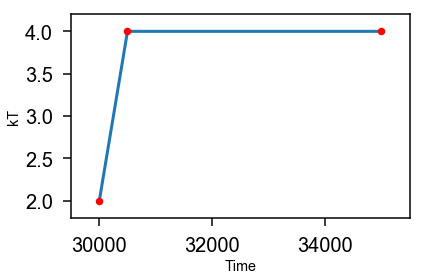

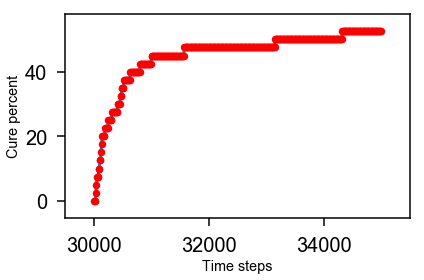

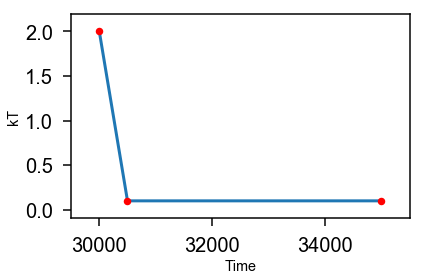

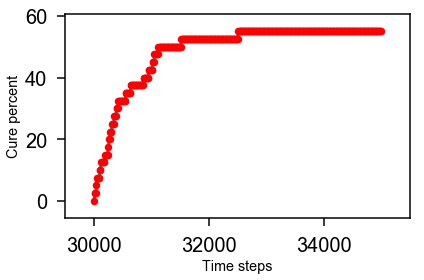

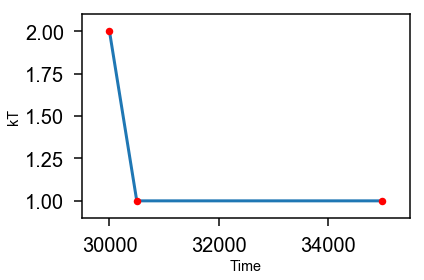

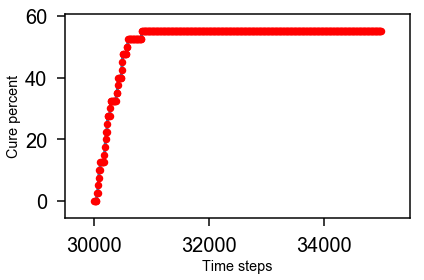

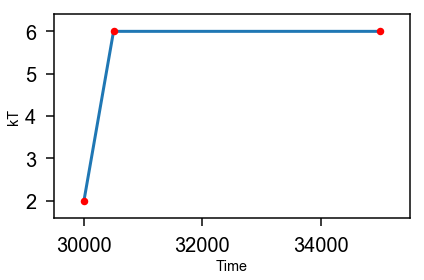

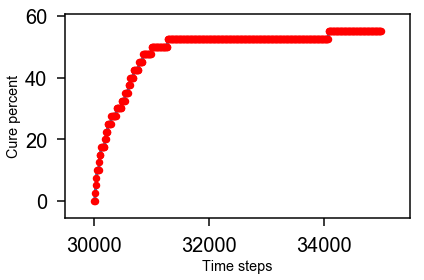

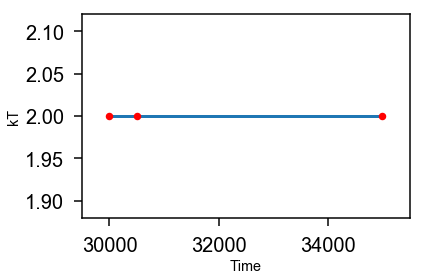

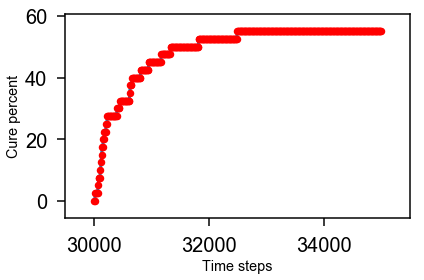

In [6]:
project = signac.init_project('ABCTypeEpoxy', 'data/')


jobs = project.find_jobs({'activation_energy':0.3,
                         'curing_log_period':1e1})
for job in jobs:
    if len(job.sp.temp_prof)>2:
        run_simulation(job.statepoint())

### Below the curing curves are visualized

/Users/stephenthomas/miniconda3/envs/epoxpy/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


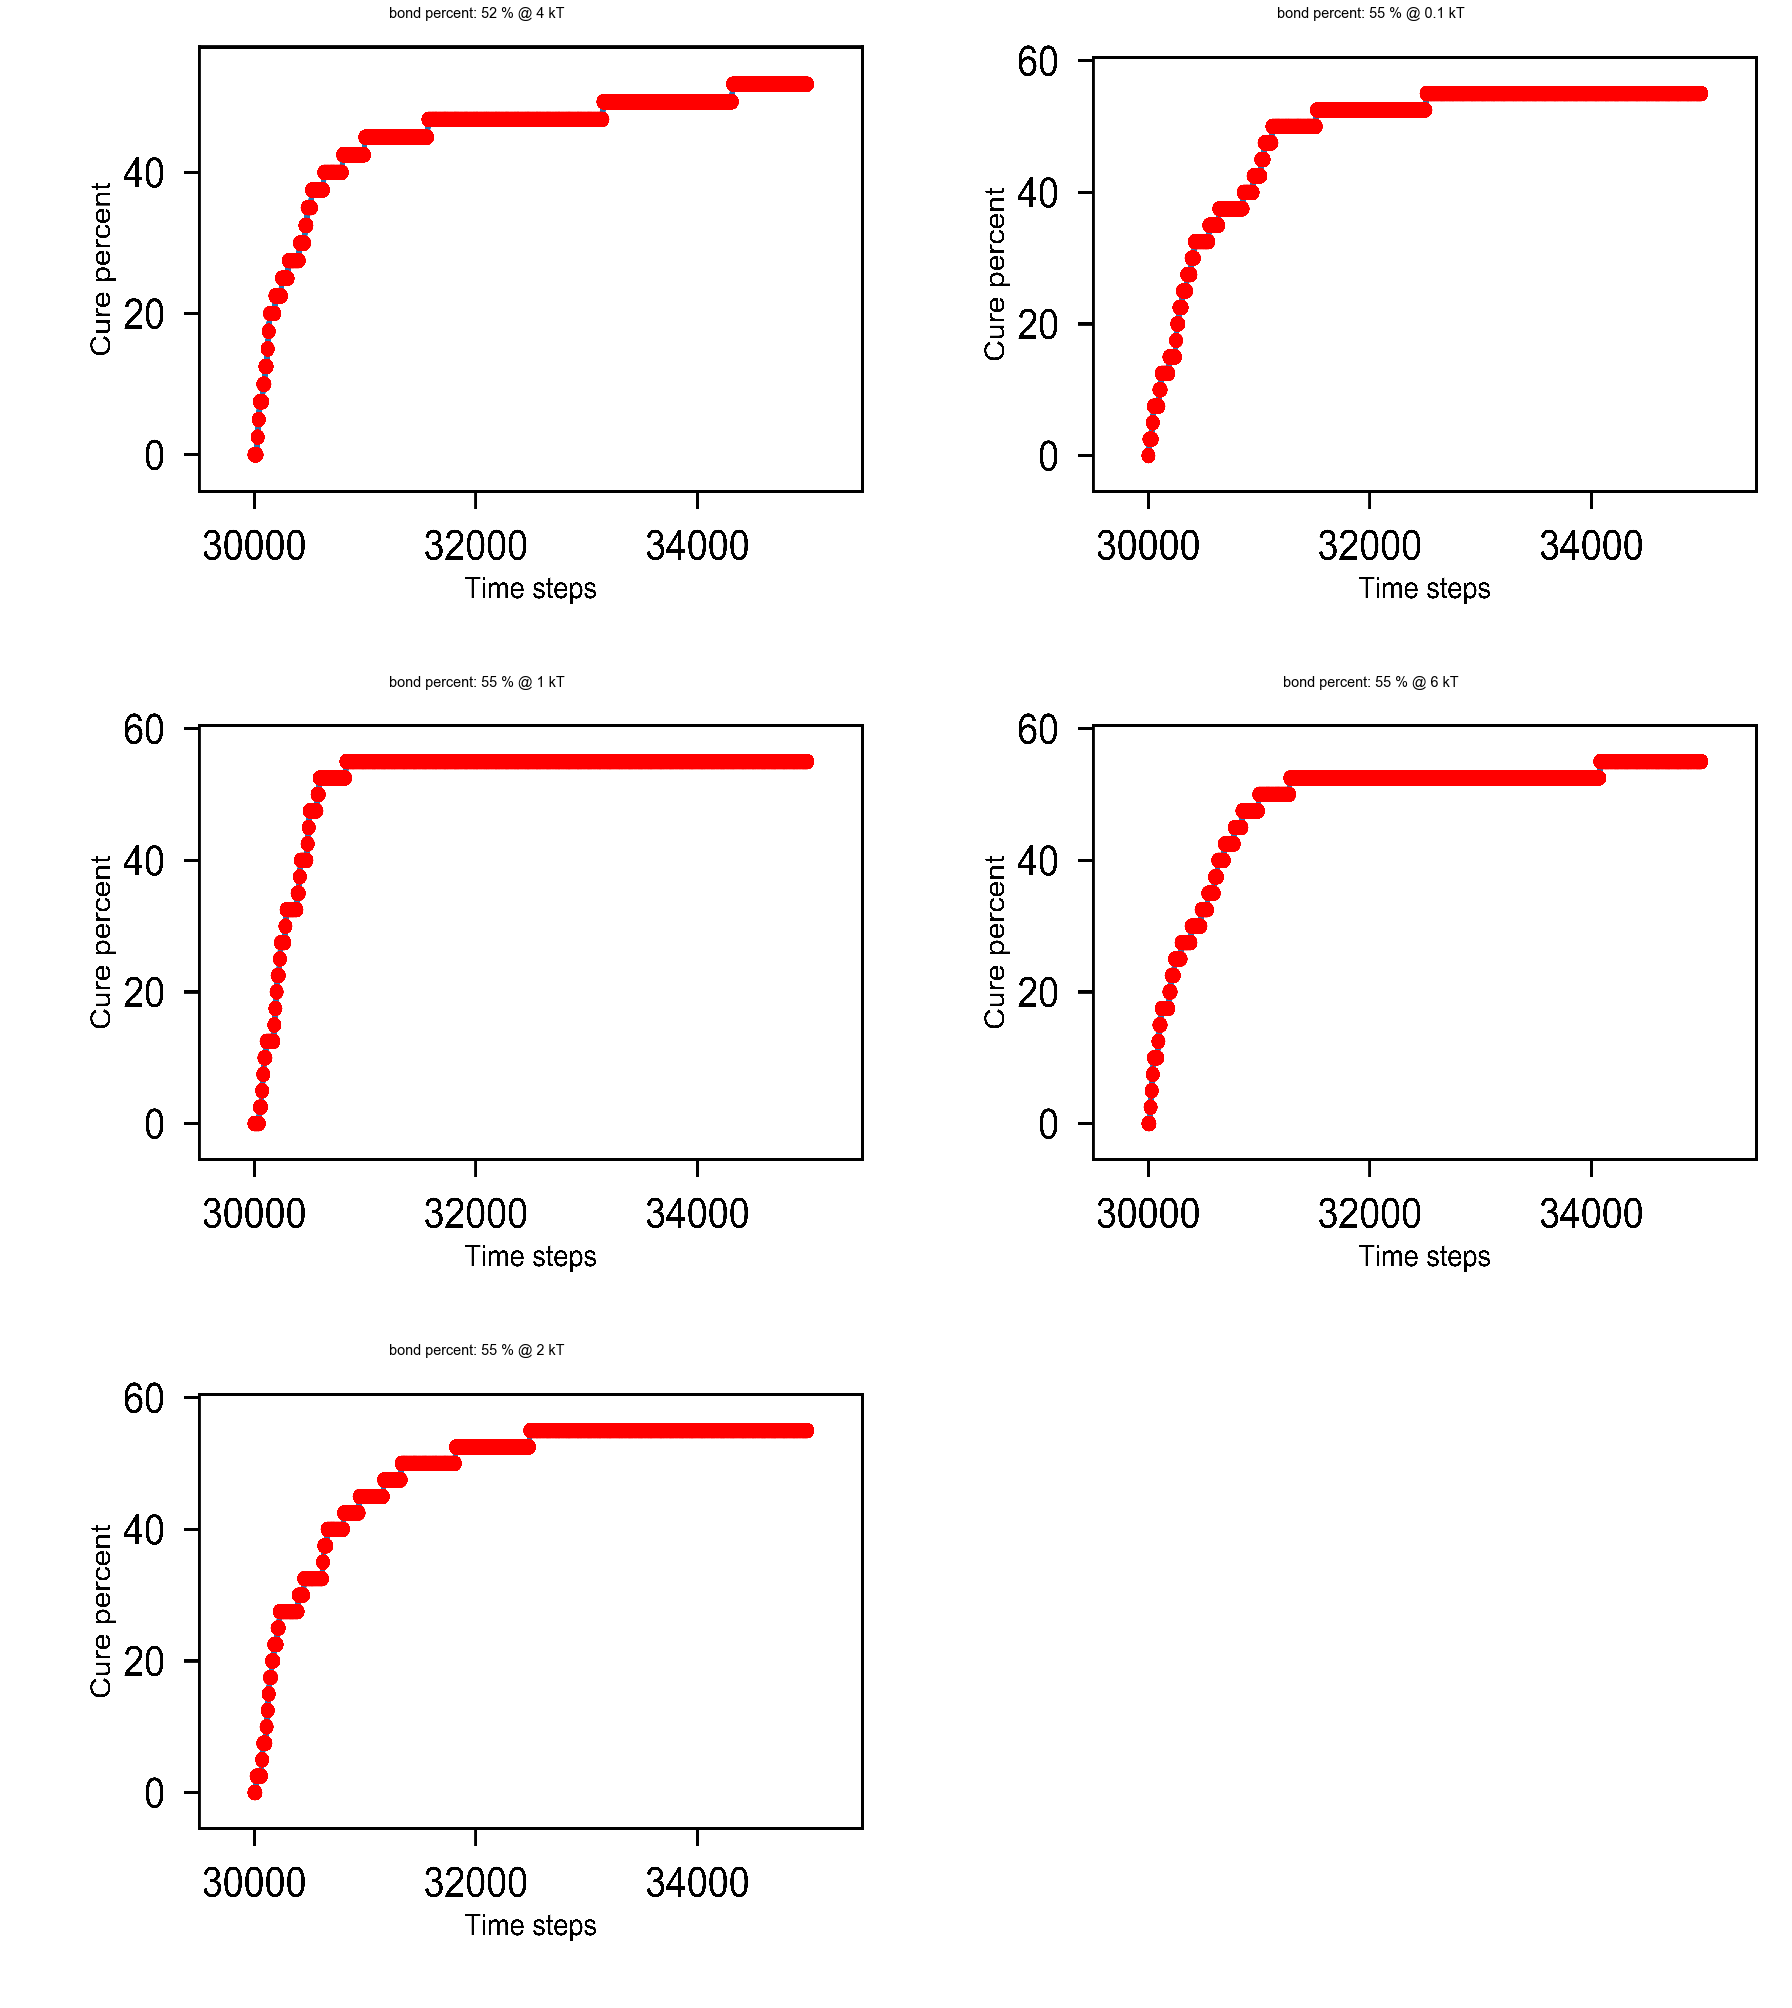

In [7]:
project = signac.init_project('ABCTypeEpoxy', 'data/')

jobs = project.find_jobs({'activation_energy':0.3,
                         'curing_log_period': 1e1})
pltid=321
plt.figure(figsize=(25,28))
for job in jobs:
    if len(job.sp.temp_prof)>2:
        ax = plt.subplot(pltid)
        img=mpimg.imread(job.fn('curing_curve.png'))
        ax.imshow(img,interpolation='nearest', aspect='auto')
        ax.set_axis_off()
        ax.set_title('bond percent: {} % @ {} kT'.format(round(job.document['bond_percent']),job.sp.temp_prof[-1][1]))
        ax.autoscale(False)
        pltid+=1
plt.show()